# Notebook to compute the state evolution for ridge regression and different resampling

**Pour ridge regression, le lambda optimal est constant a $\sigma^2$**

TODO : Add the plots + state evolution to compute the bias

In [2]:
using BootstrapAsymptotics
using ProgressBars
using JSON
using Revise
using StableRNGs

using Colors
using Plots
using ProgressMeter
using Statistics

In [67]:
alpha_range    = exp10.(range(-1.0, stop=3.0, length=50))
lambda         = 0.01
noise_variance = 1.0
max_weight     = 20
rtol           = 1e-20
max_iteration  = 10000

# parameters for experiments
K = 20 # number of bootstrap resampling

20

In [50]:
algos = [
    PairBootstrap(10),
    ResidualBootstrap(),
    Subsampling(0.8),
    Subsampling(0.99),
    BayesOpt(),
    # 
    FullResampling(),
    LabelResampling(),

]

# define color for each algo
colors = distinguishable_colors(
    length(algos), [RGB(1, 1, 1), RGB(0, 0, 0)]; dropseed=true
)

filenames = Dict(
    PairBootstrap(10) => "data/ridge/ridge_pair_bootstrap_overlaps_lambda=$lambda.json",
    ResidualBootstrap() => "data/ridge/ridge_residual_bootstrap_overlaps_lambda=$lambda.json",
    Subsampling(0.8) => "data/ridge/ridge_subsampling_08_overlaps_lambda=$lambda.json",
    Subsampling(0.99) => "data/ridge/ridge_subsampling_099_overlaps_lambda=$lambda.json",
    FullResampling() => "data/ridge/ridge_full_resampling_overlaps_lambda=$lambda.json",
    LabelResampling() => "data/ridge/ridge_label_resampling_overlaps_lambda=$lambda.json",
    BayesOpt() => "data/ridge/ridge_bayes_optimal_overlaps_lambda=$lambda.json",
)

## 

# combination algos to run to compute the bias

algos_for_bias = [
    (PairBootstrap(10), FullResampling()),   
    (ResidualBootstrap(), LabelResampling()),
    (Subsampling(0.8), FullResampling()),
    (Subsampling(0.99), FullResampling())
]

filenames_for_bias = Dict(
    (PairBootstrap(10), FullResampling())    => "data/ridge/ridge_pair_bootstrap_bias_lambda=$lambda.json",
    (ResidualBootstrap(), LabelResampling()) => "data/ridge/ridge_residual_bootstrap_bias_lambda=$lambda.json",
    (Subsampling(0.8), FullResampling())     => "data/ridge/ridge_subsampling_08_bias_lambda=$lambda.json",
    (Subsampling(0.99), FullResampling())    => "data/ridge/ridge_subsampling_099_bias_lambda=$lambda.json",
)

## 
exp_filenames = Dict(
    PairBootstrap(10)   => "data/ridge/exp_ridge_pair_bootstrap_bias_variance_lambda=$lambda.json",
    ResidualBootstrap() => "data/ridge/exp_ridge_residual_bootstrap_bias_variance_lambda=$lambda.json",
    Subsampling(0.8)  => "data/ridge/exp_ridge_subsampling_08_bias_variance_lambda=$lambda.json",
    Subsampling(0.99) => "data/ridge/exp_ridge_subsampling_099_bias_variance_lambda=$lambda.json",
    FullResampling()  => "data/ridge/exp_ridge_full_resampling_bias_variance_lambda=$lambda.json",
    LabelResampling() => "data/ridge/exp_ridge_label_resampling_bias_variance_lambda=$lambda.json",
    BayesOpt()        => "data/ridge/exp_ridge_bayes_optimal_bias_variance_lambda=$lambda.json",
)


Dict{BootstrapAsymptotics.Algorithm, String} with 7 entries:
  Subsampling(0.99)         => "data/ridge/exp_ridge_subsampling_099_bias_varia…
  FullResampling()          => "data/ridge/exp_ridge_full_resampling_bias_varia…
  BayesOpt{NUTS{AutoRevers… => "data/ridge/exp_ridge_bayes_optimal_bias_varianc…
  PairBootstrap(10)         => "data/ridge/exp_ridge_pair_bootstrap_bias_varian…
  LabelResampling()         => "data/ridge/exp_ridge_label_resampling_bias_vari…
  ResidualBootstrap()       => "data/ridge/exp_ridge_residual_bootstrap_bias_va…
  Subsampling(0.8)          => "data/ridge/exp_ridge_subsampling_08_bias_varian…

In [18]:
function save_overlaps(filename::String, alpha_range::Vector, algo::BootstrapAsymptotics.Algorithm, overlaps::Vector, hatoverlaps::Vector)
    dict_to_save = Dict("alpha" => alpha_range,
        "m"   => [o.m[1] for o in overlaps],
        "q_diag"   => [o.Q[1, 1] for o in overlaps],
        "q_off_diag"   => [o.Q[1, 2] for o in overlaps],
        "v"   => [o.V[1] for o in overlaps],

        "mhat"=> [o.m[1] for o in hatoverlaps],
        "qhat_diag"=> [o.Q[1, 1] for o in hatoverlaps],
        "qhat_off_diag"=> [o.Q[1, 2] for o in hatoverlaps],
        "vhat"=> [o.V[1] for o in hatoverlaps],
    )

    if typeof(algo) == Subsampling
        dict_to_save["proba"] = [algo.r]
    end

    open(filename, "w") do f
        write(f, JSON.json(dict_to_save))
    end
end

function save_overlaps_for_bias(filename::String, alpha_range::Vector, algo1::BootstrapAsymptotics.Algorithm, algo2::BootstrapAsymptotics.Algorithm, overlaps::Vector)
    # by convention algo2 is the "true" resampling (FullResampling or LabelResampling) and algo1 is the resampling estimator
    dict_to_save = Dict("alpha" => alpha_range,
        "q_off_diag"   => [o.Q[1, 2] for o in overlaps],
    )

    if typeof(algo1) == Subsampling
        dict_to_save["proba"] = [algo1.r]
    end

    open(filename, "w") do f
        write(f, JSON.json(dict_to_save))
    end
end

function save_exp_bias_variance(filename::String, alpha_range::Vector, algo::BootstrapAsymptotics.Algorithm, bias_list::Vector, variance_list::Vector)
    dict_to_save = Dict("alpha" => alpha_range,
        "bias"  => bias_list,
        "var"   => variance_list,
    )

    if typeof(algo) == Subsampling
        dict_to_save["proba"] = [algo.r]
    end

    open(filename, "w") do f
        write(f, JSON.json(dict_to_save))
    end
end

save_exp_bias_variance (generic function with 1 method)

In [6]:
# used for residual bootstrap
function get_train_error(m, q, v, noise_variance; rho = 1.0)
    return (rho + noise_variance + q - 2.0 * m) / (1+v)^2
end

get_train_error (generic function with 1 method)

In [31]:
# theoretical overlaps
for algo in algos
    if algo == ResidualBootstrap()
        continue
    end

    overlaps_list    = []
    hatoverlaps_list = []
    println("Computing $algo")
    for i in eachindex(alpha_range)
        α = alpha_range[i]
        if algo == BayesOpt()
            problem = Ridge(α = α, Δ = noise_variance, ρ = 1.0, λ = 1.0)
        else
            problem = Ridge(α = α, Δ = noise_variance, ρ = 1.0, λ = lambda)
        end

        result = state_evolution(problem, algo, algo, rtol=1e-8, max_iteration=100)
        push!(overlaps_list, result.overlaps)
        push!(hatoverlaps_list, result.hatoverlaps)

    end
    save_overlaps(filenames[algo], alpha_range, algo, overlaps_list, hatoverlaps_list)
end

algo = ResidualBootstrap()
overlaps_list    = []
hatoverlaps_list = []

for i in eachindex(alpha_range)
    α = alpha_range[i]
    problem = Ridge(α = α, Δ = noise_variance, ρ = 1.0, λ = lambda)

    result_erm = state_evolution(problem, FullResampling(), FullResampling(), rtol=1e-8, max_iteration=100)
    train_error = get_train_error(result_erm.overlaps.m[1], result_erm.overlaps.Q[1, 1], result_erm.overlaps.V[1], noise_variance; rho = 1.0)
    
    problem_res = Ridge(α = α, Δ = train_error, ρ = result_erm.overlaps.Q[1, 1], λ = lambda)

    result_res = state_evolution(problem_res, LabelResampling(), LabelResampling(), rtol=1e-8, max_iteration=100)
    
    push!(overlaps_list, result_res.overlaps)
    push!(hatoverlaps_list, result_res.hatoverlaps)
end
save_overlaps(filenames[algo], alpha_range, algo, overlaps_list, hatoverlaps_list)

Computing PairBootstrap(10)


Computing Subsampling(0.8)
Computing Subsampling(0.99)
Computing BayesOpt{Turing.Inference.NUTS{ADTypes.AutoReverseDiff, (), AdvancedHMC.DiagEuclideanMetric}}(Turing.Inference.NUTS{ADTypes.AutoReverseDiff, (), AdvancedHMC.DiagEuclideanMetric}(-1, 0.65, 10, 1000.0, 0.0, ADTypes.AutoReverseDiff(false)), 100)


Computing FullResampling()
Computing LabelResampling()


8764

In [68]:
rng = StableRNG(0)

α_range_experimental = exp10.(range(-1.0, stop=2.0, length=10))
d = 150

bias_emp = Dict(algo => fill(NaN, length(α_range_experimental)) for algo in algos)
vars_emp = Dict(algo => fill(NaN, length(α_range_experimental)) for algo in algos)

for algo in algos
    println("Computing empirics for $algo")
    for i in eachindex(α_range_experimental)
        α = α_range_experimental[i]
        n = ceil(Int, d * α)
        
        if algo == BayesOpt()
            problem = Ridge(α = α, Δ = noise_variance, ρ = 1.0, λ = 1.0)
        else
            problem = Ridge(α = α, Δ = noise_variance, ρ = 1.0, λ = lambda)
        end

        if algo != FullResampling() && algo != LabelResampling()
            bias, var = bias_variance_empirical(rng, problem, algo; n = n, K = K)
        elseif algo == FullResampling()
            bias, var = bias_variance_true(rng, problem; n = n, K, conditional=false)
        elseif algo == LabelResampling()
            bias, var = bias_variance_true(rng, problem; n = n, K, conditional=true)
        end
        bias_emp[algo][i] = bias
        vars_emp[algo][i] = var
    end
    save_exp_bias_variance(exp_filenames[algo], α_range_experimental, algo, bias_emp[algo], vars_emp[algo])
end

Computing empirics for PairBootstrap(10)


Computing empirics for ResidualBootstrap()


Computing empirics for Subsampling(0.8)


Computing empirics for Subsampling(0.99)


Computing empirics for BayesOpt{Turing.Inference.NUTS{ADTypes.AutoReverseDiff, (), AdvancedHMC.DiagEuclideanMetric}}(Turing.Inference.NUTS{ADTypes.AutoReverseDiff, (), AdvancedHMC.DiagEuclideanMetric}(-1, 0.65, 10, 1000.0, 0.0, ADTypes.AutoReverseDiff(false)), 100)


Computing empirics for FullResampling()


Computing empirics for LabelResampling()


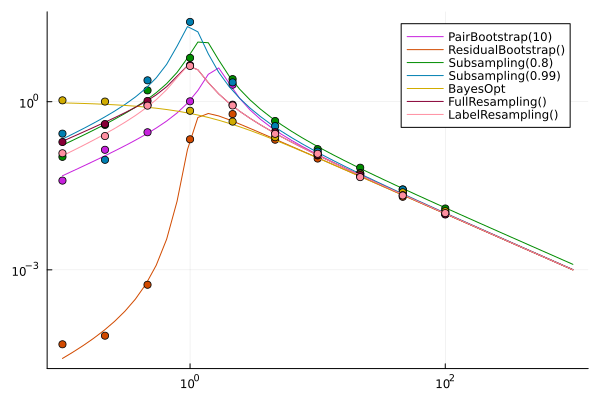

In [115]:
# load the overlaps from pairbootstrap file 

pl = plot()
for i in eachindex(algos)
    algo = algos[i]
    f = open(filenames[algo], "r")
    data = JSON.parse(String(read(f)))
    close(f)

    f_exp = open(exp_filenames[algo], "r")
    data_exp = JSON.parse(String(read(f_exp)))
    close(f_exp)

    if algo != BayesOpt()
        variance = data["q_diag"] .- data["q_off_diag"]
    else 
        variance = 1.0 .- data["q_diag"]
    end
    scaling = 1.0
    if algo isa Subsampling
        scaling = 1.0 / (1.0 - data["proba"][1])
    end
    label = "$algo"
    if algo == BayesOpt()
        label = "BayesOpt"
    end
    plot!(alpha_range, variance .* scaling, yscale=:log10, xscale=:log10, label=label, color=colors[i])
    # put no label for the scatter
    scatter!(data_exp["alpha"], scaling * K / (K - 1) * data_exp["var"], label="", color=colors[i])
end

display(pl)

---

### Computation of the bias

In [70]:
for (algo1, algo2) in algos_for_bias
    overlaps_list = []
    for α in alpha_range
        problem = Ridge(α = α, λ = lambda, ρ = 1.0)
        res = state_evolution(problem, algo1, algo2, rtol=1e-5, max_iteration=100)
        push!(overlaps_list, res.overlaps)
    end
    println([o.Q[1, 2] for o in overlaps_list])
    filename = filenames_for_bias[(algo1, algo2)]
    save_overlaps_for_bias(filename, alpha_range, algo1, algo2, overlaps_list)
end

[0.1281494527804107, 0.15570415983921282, 0.18948232894991135, 0.23104745345524696, 0.2824448664128801, 0.346403478020805, 0.4266549892311389, 0.5284618395201978, 0.6595230938388408, 0.8315654604634789, 1.0629315742419416, 1.3798651680155574, 1.7840892066889058, 2.1133225641670506, 2.259400077458163, 2.1648200138034244, 1.8817980174219608, 1.6511275431734334, 1.4902947442903671, 1.3766474582837096, 1.293996321036912, 1.2323253446679763, 1.1853467358627559, 1.1489689784040003, 1.1204322661608568, 1.0978144305138404, 1.079739362285072, 1.0651985211866264, 1.053438000869984, 1.0438847281331587, 1.0360969016053416, 1.0297298813535989, 1.02451211959817, 1.0202278429971905, 1.0167044329816457, 1.0138029520466183, 1.011411032400128, 1.0094374223695115, 1.0078077684175923, 1.006461299882975, 1.0053482518779995, 1.0044277760613518, 1.003666292751362, 1.0030361599464088, 1.0025145976946301, 1.0020828152894248, 1.0017253006118545, 1.0014292398218714, 1.0011840439535782, 1.0009809521223072]
[0.163

 1.0244523948654878, 1.0201781435369353, 1.0166631856771864, 1.0137686552641028, 1.0113825391445916, 1.0094137647510777, 1.007788130984547, 1.0064450086287409, 1.0053347395062537, 1.0044165704887789, 1.0036570014578363, 1.0030284567800518, 1.0025082117906214, 1.0020775310106287, 1.00172091816745, 1.0014256061072748, 1.0011810299130537, 1.0009784541282165]
[0.2040660734022734, 0.24906539272997458, 0.3048480088663745, 0.3744924266055722, 0.46227855265888973, 0.5743844372300172, 0.7201464209195269, 0.9146093049717103, 1.1839955410103928, 1.5789559462545746, 2.2095189498251036, 3.327889512142157, 5.019997339439215, 4.57818541795064, 3.1338593861370985, 2.3484467640421998, 1.9212532722618814, 1.663689863262031, 1.4954471250595767, 1.3791076684167067, 1.2952904523387563, 1.2330517910195482, 1.1857737759322593, 1.1492264781313497, 1.120591107787783, 1.097914370190148, 1.0798024291293296, 1.0652385533959845, 1.0534637620118035, 1.0439009606203946, 1.036107061304289, 1.029736149869307, 1.024515

(PairBootstrap(10), FullResampling())Any[0.1281494527804107, 0.15570415983921282, 0.18948232894991135, 0.23104745345524696, 0.2824448664128801, 0.346403478020805, 0.4266549892311389, 0.5284618395201978, 0.6595230938388408, 0.8315654604634789, 1.0629315742419416, 1.3798651680155574, 1.7840892066889058, 2.1133225641670506, 2.259400077458163, 2.1648200138034244, 1.8817980174219608, 1.6511275431734334, 1.4902947442903671, 1.3766474582837096, 1.293996321036912, 1.2323253446679763, 1.1853467358627559, 1.1489689784040003, 1.1204322661608568, 1.0978144305138404, 1.079739362285072, 1.0651985211866264, 1.053438000869984, 1.0438847281331587, 1.0360969016053416, 1.0297298813535989, 1.02451211959817, 1.0202278429971905, 1.0167044329816457, 1.0138029520466183, 1.011411032400128, 1.0094374223695115, 1.0078077684175923, 1.006461299882975, 1.0053482518779995, 1.0044277760613518, 1.003666292751362, 1.0030361599464088, 1.0025145976946301, 1.0020828152894248, 1.0017253006118545, 1.0014292398218714, 1.0011

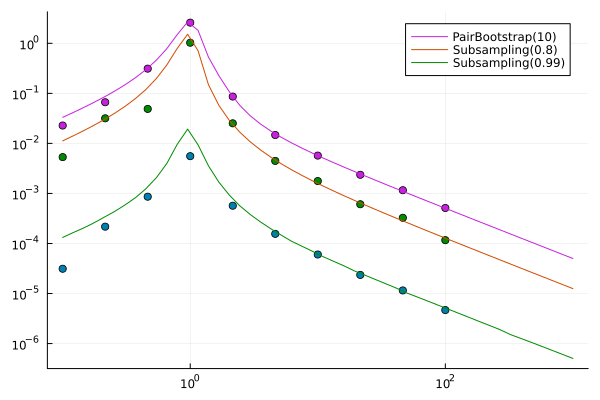

1.097914370190148, 1.0798024291293296, 1.0652385533959845, 1.0534637620118035, 1.0439009606203946, 1.036107061304289, 1.029736149869307, 1.0245158884175027, 1.0202301812132126, 1.0167056836927424, 1.0138035369936749, 1.0114112174119632, 1.009437375168294, 1.0078075910620832, 1.0064610628489434, 1.0053479941112566, 1.004427520615268, 1.0036660524964907, 1.0030359700094242, 1.002514419507065, 1.0020826542499164, 1.00172515848694, 1.0014291163816444, 1.0011839363220572, 1.000980860889053]


In [79]:
pl = plot(xaxis=:log10, yaxis=:log10)
for i in eachindex(algos)
    algo = algos[i]
    if algo == BayesOpt() || !(algo isa Subsampling || algo isa PairBootstrap)
        continue
    end

    f_exp = open(exp_filenames[algo], "r")
    data_exp = JSON.parse(String(read(f_exp)))
    close(f_exp)

    scaling = 1.0
    scatter!(data_exp["alpha"],  scaling .* data_exp["bias"], label="", color=colors[i])
end

for i in eachindex(algos_for_bias)
    (algo1, algo2) = algos_for_bias[i]
    if !(algo1 isa Subsampling || algo1 isa PairBootstrap)
        continue
    end
    
    f_correlation = open(filenames_for_bias[(algo1, algo2)], "r")
    data_correlation = JSON.parse(String(read(f_correlation)))
    
    f_1 = open(filenames[algo1], "r")
    data_1 = JSON.parse(String(read(f_1)))
    
    f_2 = open(filenames[algo2], "r")
    data_2 = JSON.parse(String(read(f_2)))

    println("$((algo1, algo2))", data_correlation["q_off_diag"])

    scaling_bias, scaling_variance = 1.0, 1.0
    if algo1 isa Subsampling
        scaling_bias = 1.0 / (1.0 - data_1["proba"][1])
    end

    bias = data_1["q_off_diag"] + data_2["q_diag"] - 2.0 .* data_correlation["q_off_diag"]
    variance = data_1["q_diag"] .- data_1["q_off_diag"]
    plot!(alpha_range, bias + variance / K, label="$algo1", color=colors[i])
end

display(pl)